In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [128]:
from mlxtend.frequent_patterns import apriori,fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

In [153]:
from pyecharts import options as opts
from pyecharts.charts import Scatter,Pie
from pyecharts.globals import ChartType,ThemeType

## 数据清洗与处理

#### 缺失值

In [9]:
transaction = pd.read_excel('DM22Final_Project.xlsx',sheet_name=0)
print(transaction.head())
print('transaction数据集共有',transaction.shape[0],'行，以及',transaction.shape[1],'个变量')

   seller_id  buyer_id  product_id  product_price  sold_quantity
0          1        71        4776           21.0           20.0
1          1       121        2837           23.0           83.0
2          1       554        3248           21.0           44.0
3          1       573        2852           27.0           29.0
4          1       573        4114           25.0          105.0
transaction数据集共有 5078 行，以及 5 个变量


In [10]:
print('数据集在 ‘sold_quantity’ 字段有',transaction.isna().sum()['sold_quantity'],'个缺失值')
print('删除缺失值所在行，共',transaction.isna().sum()['sold_quantity'],'行')
transaction=transaction.dropna()
transaction.index=range(len(transaction))
print('transaction数据集共有',transaction.shape[0],'行，以及',transaction.shape[1],'个变量')

数据集在 ‘sold_quantity’ 字段有 2 个缺失值
删除缺失值所在行，共 2 行
transaction数据集共有 5076 行，以及 5 个变量


#### 异常值

In [12]:
df1 = transaction.loc[:,['product_id','seller_id','product_price','sold_quantity']].drop_duplicates(subset=['product_id','seller_id'], keep='first', inplace=False, ignore_index=True)
df2 = transaction.loc[:,['product_id','seller_id','product_price','sold_quantity']].drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
pd.concat([df1,df2]).drop_duplicates(keep=False)

,product_id,seller_id,product_price,sold_quantity
27,4114,1,21.0,105.0
31,4127,1,25.0,180.0
33,4112,1,25.0,58.0
722,161,3550,49.0,10815.0
775,5046,3819,59.0,162.0


In [14]:
# 发现会出现同一个product以不同的价格购买的问题，在product表中储存为两列
transaction[transaction['product_id']==4114]

,seller_id,buyer_id,product_id,product_price,sold_quantity
4,1,573,4114,25.0,105.0
44,1,1172,4114,21.0,105.0
71,1,1974,4114,25.0,105.0
92,1,2676,4114,21.0,105.0
122,1,3698,4114,21.0,105.0
145,1,4863,4114,21.0,105.0


### 产品信息整理

In [57]:
product=df2.sort_values(by=['product_id'])
#以一组（product_id，product_price）标识一件商品
product=product.set_index(['product_id','product_price'])
product['count']=transaction.groupby(['product_id','product_price'])['seller_id'].count()
product=product.reset_index().sort_values(by='sold_quantity',ignore_index=True)
product.head()

,product_id,product_price,seller_id,sold_quantity,count
0,4850,48.00,3706,0.0,1
1,4693,22.00,976,0.0,1
2,4700,20.00,976,0.0,1
3,4671,85.00,3436,0.0,1
4,4670,37.24,2800,0.0,1


Text(0.5, 0, 'product price')

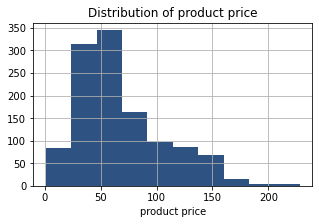

In [58]:
plt.figure(figsize=(5,3)) 
product['product_price'].hist(bins=10,color='#2e5282')
plt.title('Distribution of product price')
plt.xlabel('product price')

In [59]:
print(np.percentile(product['product_price'], [40, 90]))
product['price_cluster']='0'
product.loc[(product['product_price']>120),['price_cluster']]='high-end'
product.loc[(product['product_price']<=120)&(product['product_price']>=50),['price_cluster']]='middle-end'
product.loc[(product['product_price']<50),['price_cluster']]='low-end'
product.groupby(['price_cluster'])['product_id'].count()

[ 49. 120.]


price_cluster
high-end      100
low-end       486
middle-end    593
Name: product_id, dtype: int64

Text(0.5, 0, 'sold quantity')

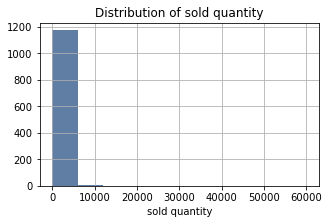

In [60]:
#product[product['sold_quantity']<=10000]['sold_quantity'].hist(bins=10)
plt.figure(figsize=(5,3)) 
product['sold_quantity'].hist(bins=10,color='#607da3')
plt.title('Distribution of sold quantity')
plt.xlabel('sold quantity')

Text(0.5, 0, 'sold quantity')

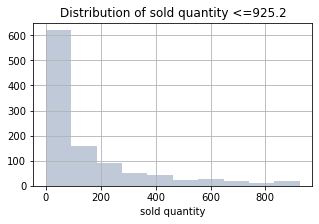

In [61]:
plt.figure(figsize=(5,3)) 
product[product['sold_quantity']<=925.2]['sold_quantity'].hist(bins=10,color='#c0c9d8')
plt.title('Distribution of sold quantity <=925.2')
plt.xlabel('sold quantity')

In [111]:
print(np.percentile(product['sold_quantity'], [50, 75, 90]))
product['quantity_cluster']='0'
product.loc[(product['sold_quantity']==0),['quantity_cluster']]='new-product'
product.loc[(product['sold_quantity']>925.2),['quantity_cluster']]='best-seller'
product.loc[(product['sold_quantity']<=925.2)&(product['sold_quantity']>303.5),['quantity_cluster']]='well-seller'
product.loc[(product['sold_quantity']<=303.5)&(product['sold_quantity']>83),['quantity_cluster']]='normal-product'
product.loc[(product['sold_quantity']<=83)&(product['sold_quantity']>0),['quantity_cluster']]='dull-product'
product.groupby(['quantity_cluster'])['product_id'].count()

[ 83.  303.5 925.2]


quantity_cluster
best-seller       118
dull-product      567
new-product        24
normal-product    293
well-seller       177
Name: product_id, dtype: int64

In [112]:
product['cluster']='0'
for i in range(len(product)):
    product['cluster'][i]=product['quantity_cluster'][i]+' ; '+product['price_cluster'][i]
product.groupby(['cluster'])['product_id'].count()

cluster
best-seller ; high-end          16
best-seller ; low-end           55
best-seller ; middle-end        47
dull-product ; high-end         42
dull-product ; low-end         219
dull-product ; middle-end      306
new-product ; high-end           2
new-product ; low-end           15
new-product ; middle-end         7
normal-product ; high-end       21
normal-product ; low-end       106
normal-product ; middle-end    166
well-seller ; high-end          19
well-seller ; low-end           91
well-seller ; middle-end        67
Name: product_id, dtype: int64

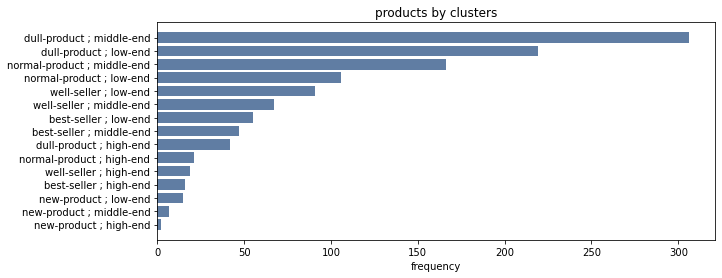

In [113]:
x=product.groupby(['cluster'])['product_id'].count().to_frame().sort_values(by='product_id',ascending=True)
data=list(x['product_id'])
labels=list(x.index)
plt.figure(figsize=(10,4))
plt.barh(range(len(data)), data,color='#607da3')
plt.yticks(range(len(data)),labels)
plt.xlabel("frequency")
plt.title("products by clusters")
plt.show()

### 订单信息整理

In [114]:
#transaction.head()
transaction['quantity_cluster']='0'
transaction.loc[(transaction['sold_quantity']==0),['quantity_cluster']]='new-product'
transaction.loc[(transaction['sold_quantity']>925.2),['quantity_cluster']]='best-seller'
transaction.loc[(transaction['sold_quantity']<=925.2)&(transaction['sold_quantity']>303.5),['quantity_cluster']]='well-seller'
transaction.loc[(transaction['sold_quantity']<=303.5)&(transaction['sold_quantity']>83),['quantity_cluster']]='normal-product'
transaction.loc[(transaction['sold_quantity']<=83)&(transaction['sold_quantity']>0),['quantity_cluster']]='dull-product'
print(transaction.groupby(['quantity_cluster'])['product_id'].count())
transaction['price_cluster']='0'
transaction.loc[(transaction['product_price']>120),['price_cluster']]='high-end'
transaction.loc[(transaction['product_price']<=120)&(transaction['product_price']>50),['price_cluster']]='middle-end'
transaction.loc[(transaction['product_price']<=50),['price_cluster']]='low-end'
print(transaction.groupby(['price_cluster'])['product_id'].count())

quantity_cluster
best-seller       2134
dull-product       991
new-product         25
normal-product     927
well-seller        999
Name: product_id, dtype: int64
price_cluster
high-end       569
low-end       2283
middle-end    2224
Name: product_id, dtype: int64


In [115]:
transaction['cluster']='0'
for i in range(len(transaction)):
    transaction['cluster'][i]=transaction['quantity_cluster'][i]+';'+transaction['price_cluster'][i]

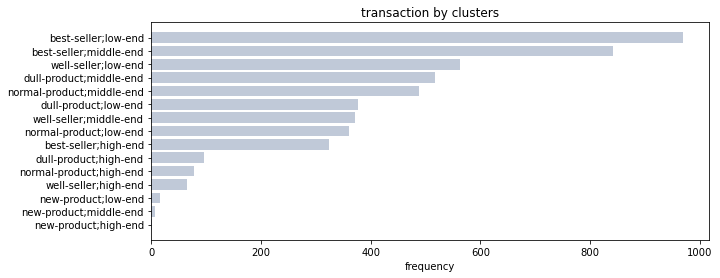

In [117]:
x=transaction.groupby(['cluster'])['product_id'].count().to_frame().sort_values(by='product_id',ascending=True)
data=list(x['product_id'])
labels=list(x.index)
plt.figure(figsize=(10,4))
plt.barh(range(len(data)), data,color='#c0c9d8')
plt.yticks(range(len(data)),labels)
plt.xlabel("frequency")
plt.title("transaction by clusters")
plt.show()

In [121]:
transaction['order_id']='0'
for i in range(len(transaction)):
    transaction['order_id'][i]=str(transaction['seller_id'][i])+'-'+str(transaction['buyer_id'][i])

In [127]:
order=transaction.groupby(['order_id'])['cluster'].apply(list).to_frame()
order.columns=['product_type']
order['product']=transaction.groupby(['order_id'])['product_id'].apply(list)
order.head()

,product_type,product
order_id,,
1-1045,[dull-product;low-end],[3360]
1-1047,"[dull-product;low-end, well-seller;low-end]","[2581, 2587]"
1-1054,"[dull-product;low-end, normal-product;low-end]","[4112, 4353]"
1-1079,[normal-product;low-end],[2915]
1-1084,[well-seller;low-end],[2587]


In [129]:
transaction.to_csv('transaction_extend.csv')

### 后续关联数据挖掘部分代码见“ARM2”

### seller信息整理

In [180]:
seller = product.groupby(['seller_id'])[['product_id']].count()
seller['sold_transaction'] = transaction.groupby(['seller_id'])['product_id'].count()
seller['product_price_mean']=transaction.groupby(['seller_id'])[['product_price']].mean()
#seller['product_price_max']=transaction.groupby(['seller_id'])[['product_price']].max()
seller['sold_quantity_sum']=transaction.groupby(['seller_id'])[['sold_quantity']].sum()
#seller['sold_quantity_max']=transaction.groupby(['seller_id'])[['sold_quantity']].max()
seller.columns=['product_number', 'sold_transaction', 'product_price_mean','sold_quantity_sum']
seller.sort_values(by='sold_transaction',ascending=False).head()

,product_number,sold_transaction,product_price_mean,sold_quantity_sum
seller_id,,,,
976,83,588,24.323129,788424.0
1575,44,546,60.613553,4267546.0
2378,53,422,137.507109,7686331.0
151,40,376,77.194149,270198.0
2809,70,355,37.539718,540395.0


In [204]:
b=seller.loc[:,['sold_quantity_sum']].sort_values(by='sold_quantity_sum',ascending=False).head(7)
b=b.reset_index()
b.loc[8,:]=['other',sum(seller['sold_quantity_sum'])-sum(b['sold_quantity_sum'])]
b['percentage']=b['sold_quantity_sum']/sum(b['sold_quantity_sum'])
b

,seller_id,sold_quantity_sum,percentage
0,2378.0,7686331.0,0.458367
1,1575.0,4267546.0,0.254491
2,3550.0,883192.0,0.052668
3,976.0,788424.0,0.047017
4,4867.0,691366.0,0.041229
5,2809.0,540395.0,0.032226
6,697.0,328421.0,0.019585
8,other,1583277.0,0.094417


In [199]:
p= (
    Pie(init_opts=opts.InitOpts(width="400px", height="400px",theme=ThemeType.WESTEROS))
    .add('',[list(z) for z in zip(b['seller_id'],b['sold_quantity_sum'])],
        rosetype="radius",
            radius=["30%", "55%"],)
    .set_global_opts(title_opts=opts.TitleOpts(title="seller竞争格局（按历史总销量）"), 
                legend_opts=opts.LegendOpts(is_show=False))
)

p.render_notebook()

In [139]:
seller2378=transaction[transaction['seller_id']==2378]
order3=seller2378.groupby(['order_id'])['product_id'].apply(list).to_frame()
order3.head()

,product_id
order_id,
2378-1004,[4843]
2378-1009,"[1450, 1924]"
2378-1035,[1924]
2378-104,[771]
2378-1058,[1924]


In [217]:
a=product[product['seller_id']==2378].groupby(['cluster'])['sold_quantity'].count().to_frame()
a['sold_quantity_sum']=product[product['seller_id']==2378].groupby(['cluster'])['sold_quantity'].sum()
a=a.reset_index()
p= (
    Pie(init_opts=opts.InitOpts(width="500px", height="400px",theme=ThemeType.WESTEROS))
    .add('',[list(z) for z in zip(a['cluster'],a['sold_quantity_sum'])],
        rosetype="radius",
        radius=["30%", "55%"],
        label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(title_opts=opts.TitleOpts(title="seller2378的产品类型（按销量）"), 
                legend_opts=opts.LegendOpts(is_show=False,type_="scroll", pos_right="right", orient="vertical"))
)

p.render_notebook()

In [225]:
product.loc[(product['seller_id']==2378)&(product['product_id']==1924)].append(product.loc[(product['seller_id']==2378)&(product['product_id']==748)])

,product_id,product_price,seller_id,sold_quantity,count,price_cluster,quantity_cluster,cluster
1178,1924,138.0,2378,59967.0,122,high-end,best-seller,best-seller ; high-end
1068,748,138.0,2378,1007.0,23,high-end,best-seller,best-seller ; high-end


### 后续关联数据挖掘部分代码见“ARM2”